# Case 2: Siemens AI-Driven Sales Forecasting

## Overview
This case study involves building a monthly sales forecasting model using real sales data from Siemens’ Smart Infrastructure Division in Germany. The objective is to apply machine learning techniques to predict future sales based on historical data and macro-economic indicators.

## Business Problem
- Manual sales forecasting is time-consuming and relies on human judgment.  
- Data is scattered across multiple sources, making it difficult to derive insights.  
- Inaccurate forecasts lead to financial losses, such as inefficient inventory management and unsatisfied customers.

## Objective
- Develop an AI-driven predictive model to automate the forecasting process.  
- Evaluate the model using Root Mean Squared Error (RMSE).  
- Submit predictions for May 2022 - February 2023 in a structured CSV format.


---

**This notebook was developed by:**
- João Venichand - 20211644  
- Gonçalo Custódio - 20211643  
- Diogo Correia - 20211586  
- Duarte Emanuel - 20240564


### 1. Import the Libraries


In [1]:
# Standard libraries
import calendar
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Statistics
from scipy.stats import zscore, boxcox
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Machine learning & forecasting
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from sklearn.linear_model import LinearRegression

# Suppress future warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)



c:\Users\jgven\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load Datasets

Import Sales Data

In [2]:
sales_data = pd.read_csv("Case2_Sales data.csv")
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0


Import Market Data

In [3]:
market_data = pd.read_excel("Case2_Market data.xlsx", header=None)
market_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,NaN,China,China,France,France,Germany,Germany,Italy,Italy,Japan,...,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index
1,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,...,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
2,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
3,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
4,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815


### 3. Sales Dataset Analysis

Check for missing values

In [4]:
missing_values = sales_data["Sales_EUR"].isna().sum()

missing_values

0

Count occurrences of 0 and non-zero Sales

In [5]:
zero_count = (sales_data["Sales_EUR"] == 0).sum()
non_zero_count = (sales_data["Sales_EUR"] != 0).sum()

print(f"Zero Sales Count: {zero_count}")
print(f"Non-Zero Sales Count: {non_zero_count}")

Zero Sales Count: 7135
Non-Zero Sales Count: 2667


Sales Distribution by Product (excluding 0 sales values)

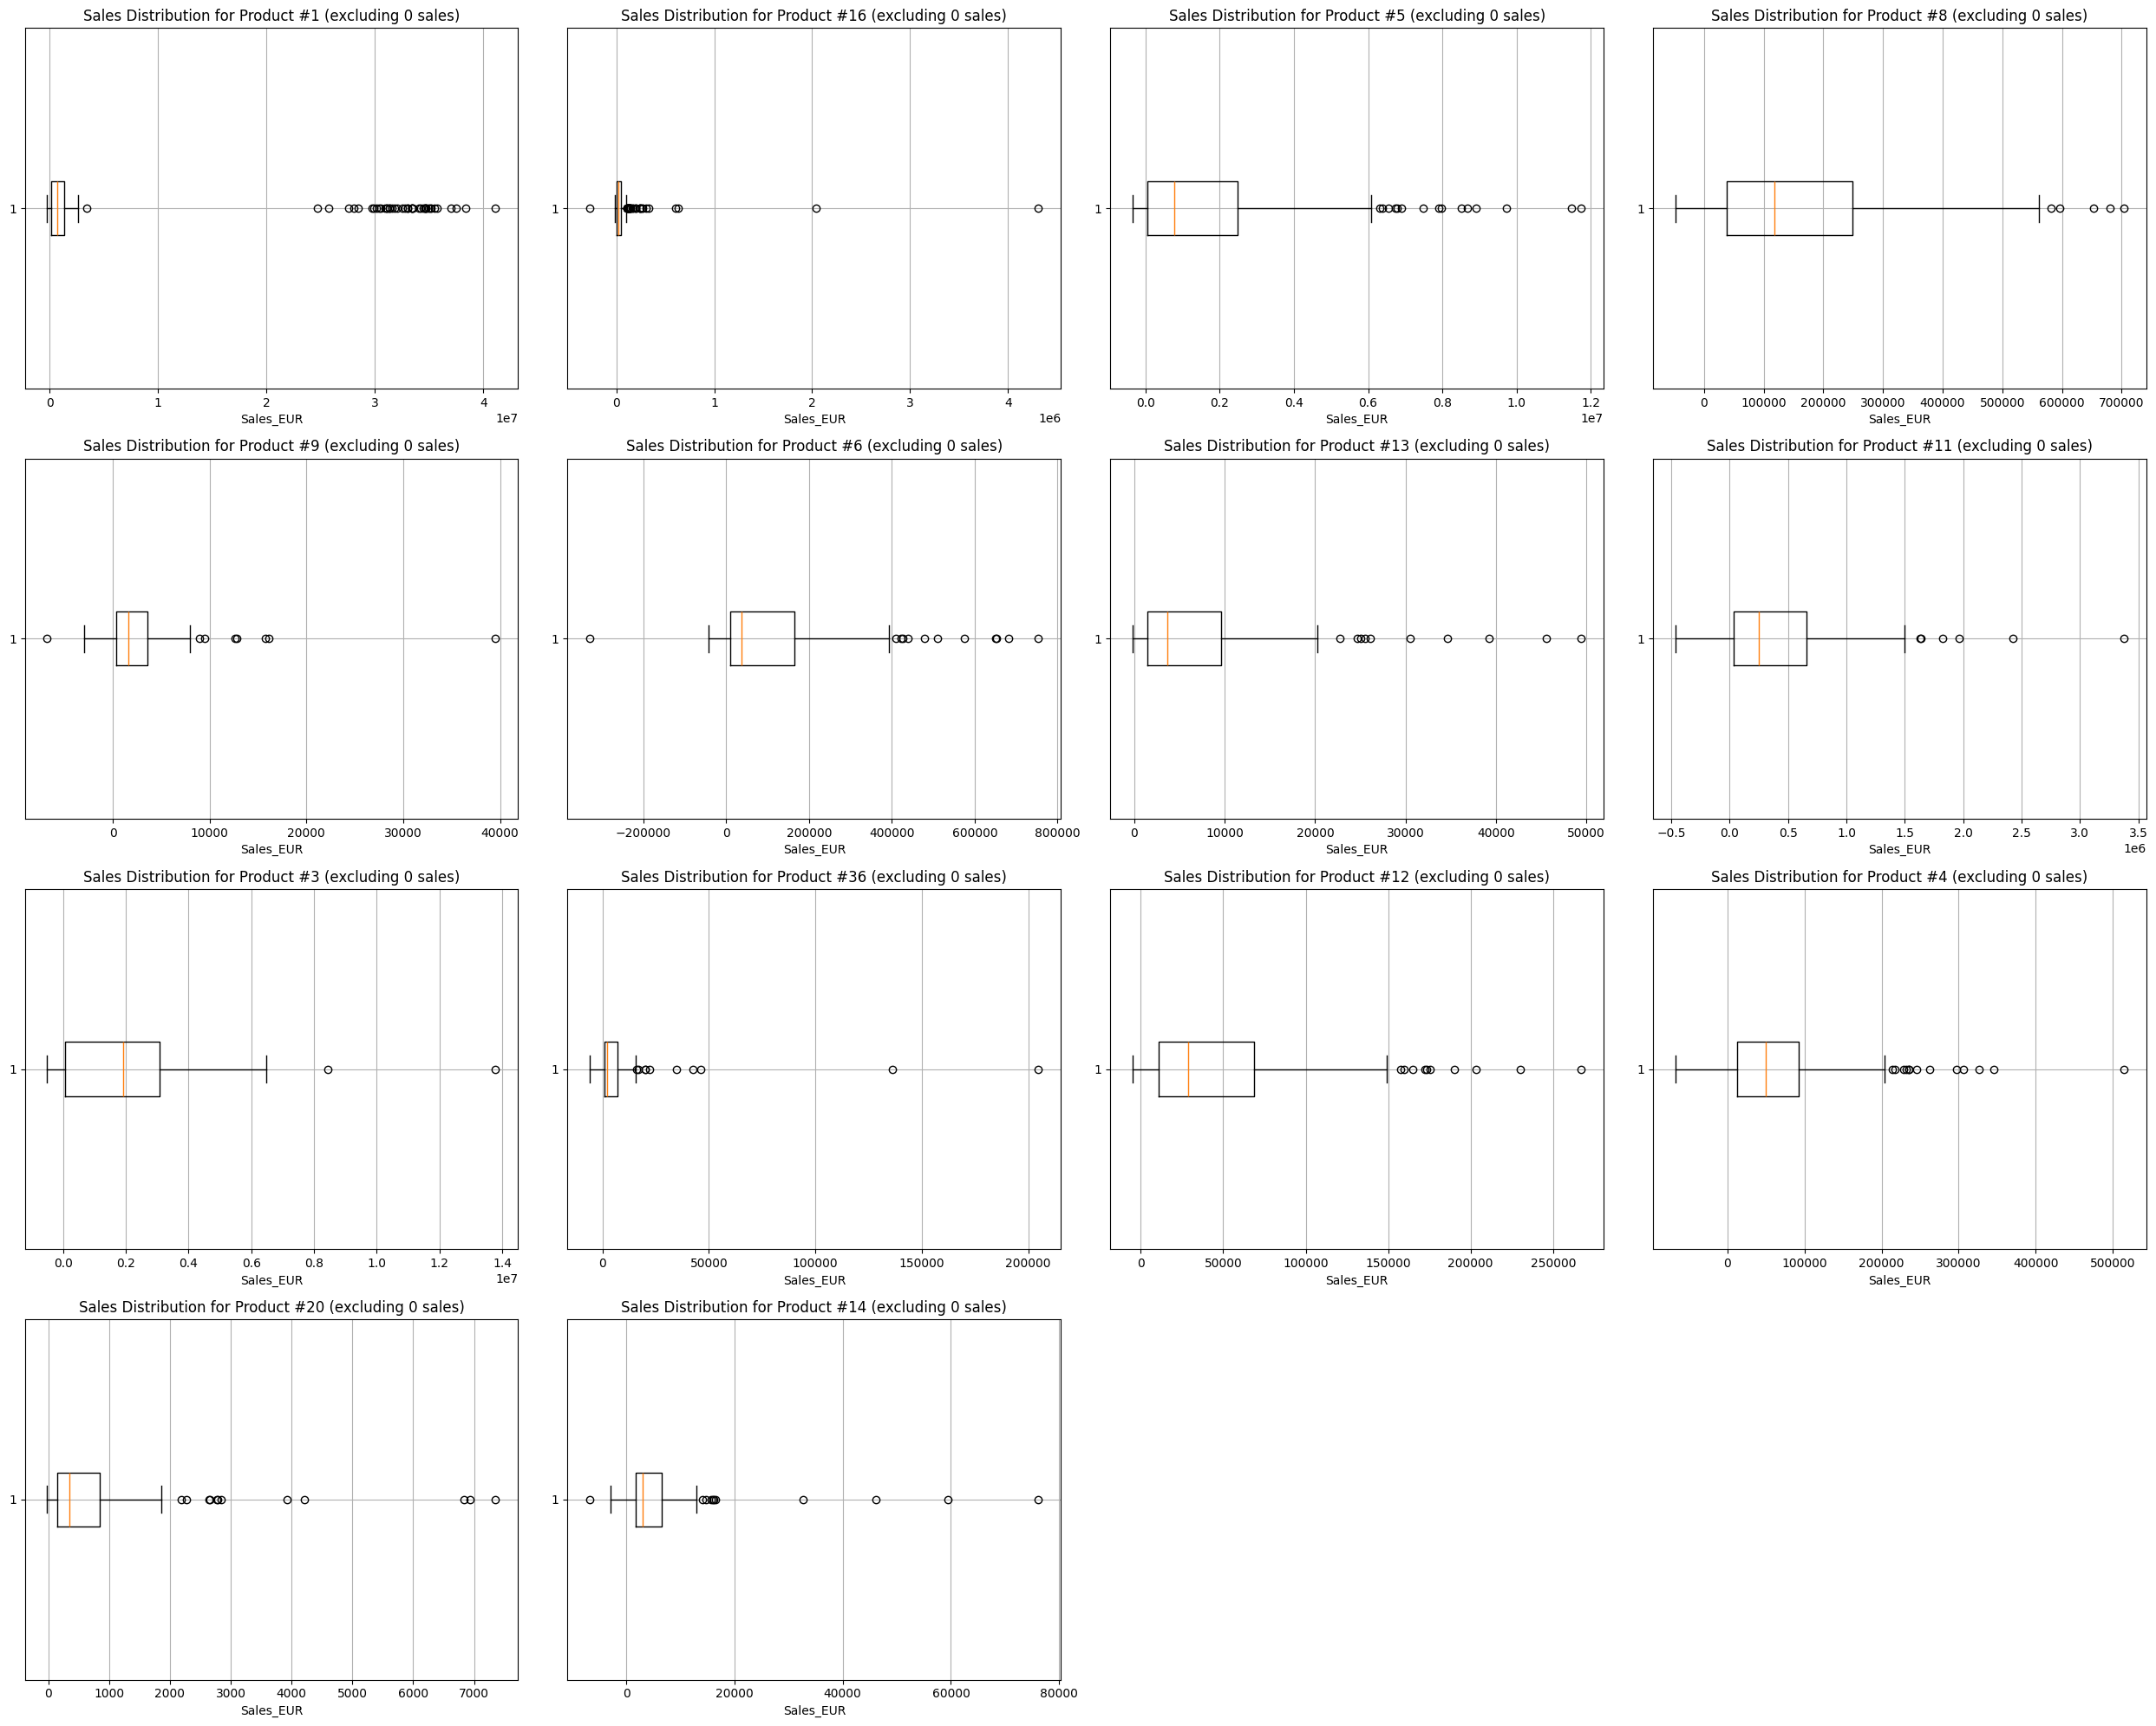

In [6]:
filtered_sales = sales_data[sales_data["Sales_EUR"] != 0]
unique_products = filtered_sales["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    product_data = filtered_sales[filtered_sales["Mapped_GCK"] == product]["Sales_EUR"]
    axes[i].boxplot(product_data, vert=False)
    axes[i].set_title(f"Sales Distribution for Product {product} (excluding 0 sales)")
    axes[i].set_xlabel("Sales_EUR")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Check for Duplicate Dates and Their Frequencies

In [7]:
sales_data["DATE"] = pd.to_datetime(sales_data["DATE"], format="%d.%m.%Y")

duplicate_dates = sales_data["DATE"].duplicated().sum()
date_counts = sales_data["DATE"].value_counts().sort_index()

print(f"Number of duplicate dates: {duplicate_dates}")
print("\nFirst 10 occurrences of dates:")
print(date_counts.head(10))

Number of duplicate dates: 8586

First 10 occurrences of dates:
DATE
2018-10-01     9
2018-10-02    10
2018-10-03     1
2018-10-04     6
2018-10-05     8
2018-10-06     1
2018-10-08     7
2018-10-09     9
2018-10-10    10
2018-10-11     8
Name: count, dtype: int64


Quantity of Different Products

In [8]:
unique_values = sales_data["Mapped_GCK"].unique()

num_unique_values = len(unique_values)

print(f"Number of unique values in Mapped_GCK: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values in Mapped_GCK: 14
Unique values:
['#1' '#11' '#6' '#8' '#12' '#16' '#4' '#5' '#3' '#9' '#14' '#13' '#20'
 '#36']


Distribution of Values by Product

In [9]:
mapped_gck_counts = sales_data["Mapped_GCK"].value_counts()
print("Count of each unique value in Mapped_GCK:")
print(mapped_gck_counts)

total_rows = len(sales_data)
print(f"\nTotal number of rows in the dataset: {total_rows}")

Count of each unique value in Mapped_GCK:
Mapped_GCK
#1     1179
#3     1017
#5      959
#8      944
#4      877
#12     803
#6      794
#16     765
#11     732
#13     441
#36     434
#9      333
#20     293
#14     231
Name: count, dtype: int64

Total number of rows in the dataset: 9802


Check for Duplicates 

In [10]:
duplicates_by_gck = sales_data.groupby("Mapped_GCK")["DATE"].apply(lambda x: x.duplicated().sum())

print("Duplicate DATEs per Mapped_GCK:")
print(duplicates_by_gck)

Duplicate DATEs per Mapped_GCK:
Mapped_GCK
#1     0
#11    0
#12    0
#13    0
#14    0
#16    0
#20    0
#3     0
#36    0
#4     0
#5     0
#6     0
#8     0
#9     0
Name: DATE, dtype: int64


Analyze Average Sales by Weekday, Month, and Year

In [11]:
sales_data["Weekday"] = sales_data["DATE"].dt.day_name()
sales_data["Year"] = sales_data["DATE"].dt.year
sales_data["Month"] = sales_data["DATE"].dt.month
weekday_sales = sales_data.groupby("Weekday")["Sales_EUR"].mean().sort_values()
month_sales = sales_data.groupby("Month")["Sales_EUR"].mean().sort_values()
year_sales = sales_data.groupby("Year")["Sales_EUR"].mean().sort_values()


In [12]:
print(weekday_sales)

Weekday
Saturday     173832.675192
Sunday       191665.814371
Tuesday      200995.492794
Wednesday    212515.561120
Thursday     221827.190011
Monday       347070.474352
Friday       403934.651971
Name: Sales_EUR, dtype: float64


In [13]:
print(month_sales)

Month
1     223989.702222
11    243629.551351
7     254406.813097
10    259941.360515
3     273163.379773
5     273221.225225
6     282490.542569
2     285487.939220
8     288530.137681
4     293675.887078
12    297922.155529
9     311129.041892
Name: Sales_EUR, dtype: float64


In [14]:
print(year_sales)

Year
2018    221508.560250
2020    265281.977690
2019    277406.693069
2021    279945.056481
2022    296520.236872
Name: Sales_EUR, dtype: float64


Visualize Average Sales per Product

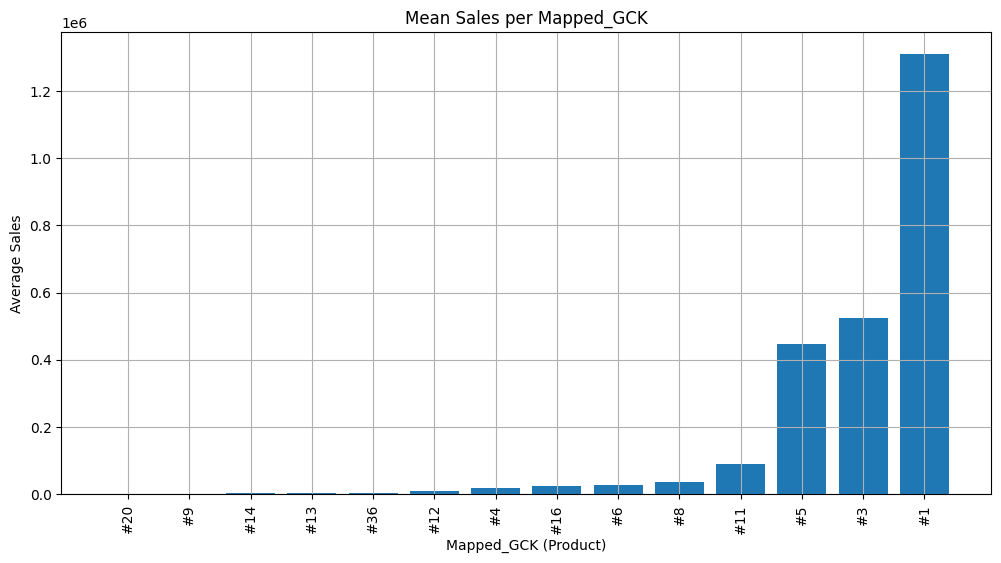

In [15]:
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

plt.figure(figsize=(12, 6))
plt.bar(mapped_gck_means.index, mapped_gck_means.values)
plt.xticks(rotation=90)
plt.xlabel("Mapped_GCK (Product)")
plt.ylabel("Average Sales")
plt.title("Mean Sales per Mapped_GCK")
plt.grid(True)
plt.show()

Mean Sales per Product

In [16]:
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

# Display the values
print("Mean Sales per Product:")
print(mapped_gck_means)


Mean Sales per Product:
Mapped_GCK
#20    2.672628e+02
#9     9.262072e+02
#14    2.137714e+03
#13    2.288236e+03
#36    2.300864e+03
#12    1.031065e+04
#4     1.781884e+04
#16    2.404064e+04
#6     2.599726e+04
#8     3.693975e+04
#11    9.002908e+04
#5     4.479615e+05
#3     5.245265e+05
#1     1.309759e+06
Name: Sales_EUR, dtype: float64


Check the Sales_Data

In [17]:
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR,Weekday,Year,Month
0,2018-10-01,#1,0,Monday,2018,10
1,2018-10-02,#1,0,Tuesday,2018,10
2,2018-10-03,#1,0,Wednesday,2018,10
3,2018-10-04,#1,0,Thursday,2018,10
4,2018-10-05,#1,0,Friday,2018,10


### 4. Market Data Analysis

 Preview first rows of Market Data

In [18]:
market_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,NaN,China,China,France,France,Germany,Germany,Italy,Italy,Japan,...,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index
1,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,...,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
2,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
3,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
4,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815


Clean and Reformat Market Data Header

In [19]:
market_data = market_data.drop(index=2).reset_index(drop=True)

new_columns = [
    f"{market_data.iloc[0, i]} - {market_data.iloc[1, i]}" if pd.notna(market_data.iloc[0, i]) 
    else market_data.iloc[1, i] 
    for i in range(market_data.shape[1])
]

market_data.columns = new_columns
market_data = market_data.iloc[2:].reset_index(drop=True)

market_data = market_data.rename(columns={market_data.columns[0]: "Date"})

Extract Year and Month from Date Column

In [20]:
market_data["Date"] = market_data["Date"].str.strip()

market_data["Year"] = market_data["Date"].str[:4].astype(int)
market_data["Month"] = market_data["Date"].str[5:].astype(int)

Validate Year and Month Extraction

In [21]:
year_counts = market_data["Year"].value_counts().sort_index()
month_counts = market_data["Month"].value_counts().sort_index()

print("Unique Years and Counts:")
print(year_counts)

print("\nUnique Months and Counts:")
print(month_counts)


Unique Years and Counts:
Year
2004    11
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022     4
Name: count, dtype: int64

Unique Months and Counts:
Month
1     18
2     19
3     19
4     19
5     18
6     18
7     18
8     18
9     18
10    18
11    18
12    18
Name: count, dtype: int64


### 5. Feature Selection

#### Selection of Key Macroeconomic Variables

Based on our analysis and discretion, we believe that the following variables are the most important for predicting Siemens' monthly sales . These variables were selected to balance **demand-side factors, cost influences, and production constraints**, while following the expert advice of using **fewer but high-value features**.

#### **Production and Shipment Indices**

- **China - Production Index Machinery & Electricals**  and **United States - Production Index Machinery & Electricals**  
   Measures industrial production in Siemens’ key client countries. Higher values may reflect increased domestic demand for Siemens-related goods.

- **China - Shipments Index Machinery & Electricals** and **United States - Shipments Index Machinery & Electricals**  
   Tracks shipment volumes in the machinery and electrical sector. Growth suggests stronger export performance and external demand.

- **Germany - Production Index Machinery & Electricals** and **Germany - Shipments Index Machinery & Electricals**  
   Reflect local industrial and distribution activity. Especially relevant as the sales data comes from a German branch.


#### **Producer Prices (Cost of Siemens' Industrial Goods)**

- **Producer Prices - United States: Electrical Equipment**  
   Reflects how costly electrical equipment is for Siemens’ U.S.-based clients. Higher prices may reduce purchasing power; lower prices could support demand.

- **Producer Prices - China: Electrical Equipment**  
   Indicates equipment costs in China, potentially affecting Siemens’ production expenses and pricing strategies.

- **Producer Prices - Germany: Electrical Equipment**  
   Relevant to local operations. Fluctuations in German producer prices may influence both profitability and sales performance, since data is from a German branch.


#### **Raw Material and Energy Costs**
- **World: Price of Base Metals**  
   Siemens’ industrial products depend on metals like steel and aluminum. Higher prices increase production costs.

- **World: Price of Energy**  
   Rising energy costs elevate manufacturing expenses, potentially influencing Siemens’ pricing strategies.

- **World: Price of Crude Oil, Average**  
   Affects transportation and supply chain costs. Significant increases may reduce industrial investment and weigh on Siemens’ sales.

- **World: Price of Copper**  
   A key input in electrical equipment manufacturing.

These selected variables cover both **demand-side** factors (production and shipments), **cost structures** (producer prices), and **macro-level influences** (raw material and energy prices). This approach ensures a balanced, minimal, and high-impact feature selection.


Correlation Analysis of Selected Macroeconomic Features

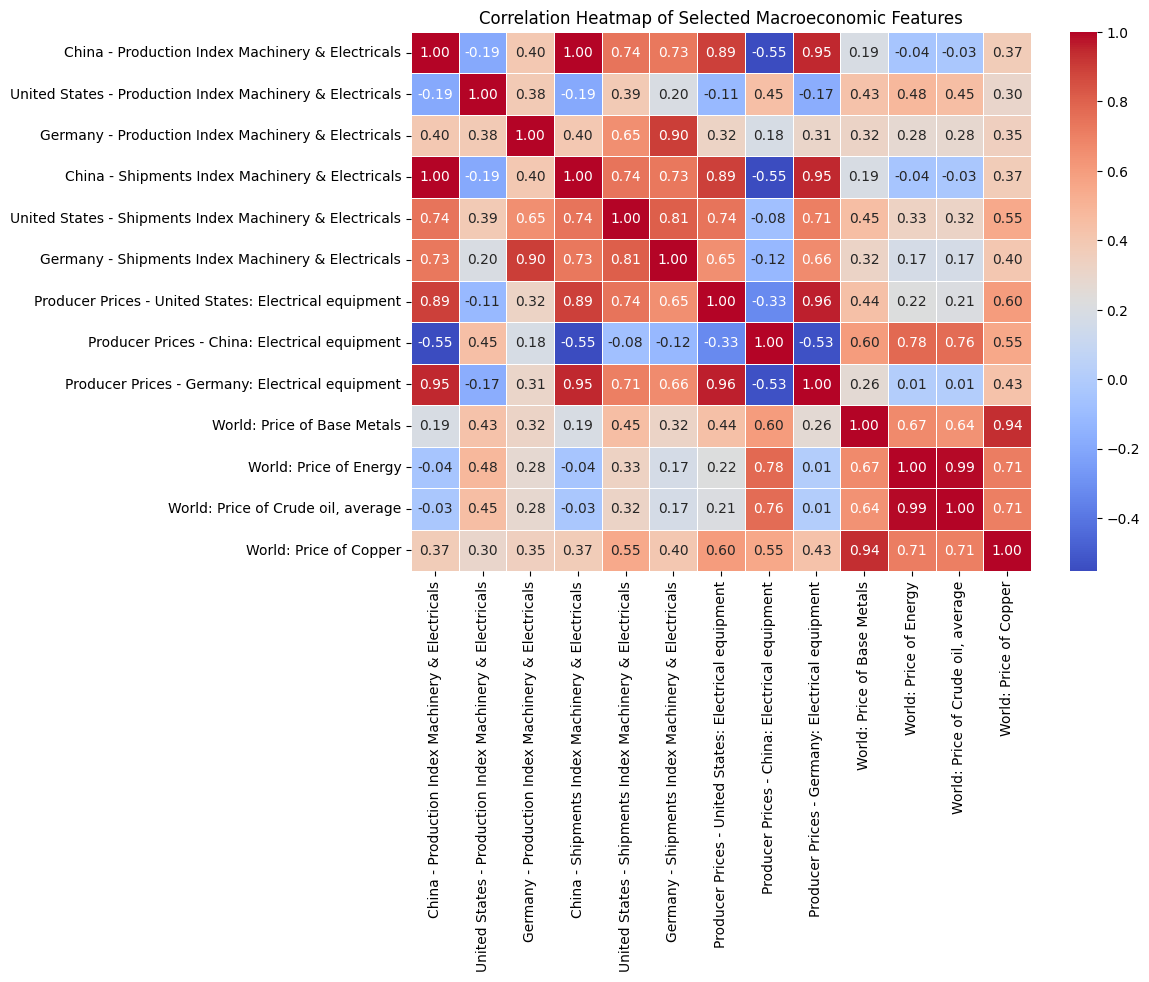

In [22]:
macro_features = [
    "China - Production Index Machinery & Electricals",
    "United States - Production Index Machinery & Electricals",
    "Germany - Production Index Machinery & Electricals",
    "China - Shipments Index Machinery & Electricals",
    "United States - Shipments Index Machinery & Electricals",
    "Germany - Shipments Index Machinery & Electricals",
    "Producer Prices - United States: Electrical equipment",
    "Producer Prices - China: Electrical equipment",
    "Producer Prices - Germany: Electrical equipment",
    "World: Price of Base Metals",
    "World: Price of Energy",
    "World: Price of Crude oil, average",
    "World: Price of Copper"
]

correlation_matrix = market_data[macro_features].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Macroeconomic Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Feature Selection Strategy

#### **Consolidating Redundant Features**
##### **China - Production Index Machinery & Electricals**
This variable exhibits **very high correlation** with multiple other features:
- **1.00** with `China - Shipments Index Machinery & Electricals`
- **0.74** with `United States - Shipments Index Machinery & Electricals`
- **0.73** with `Germany - Shipments Index Machinery & Electricals`
- **0.89** with `Producer Prices - United States: Electrical Equipment`
- **0.95** with `Producer Prices - Germany: Electrical Equipment`

Given this extreme correlation, we will **retain "China - Production Index Machinery & Electricals" as a representative variable**, allowing it to encapsulate the information from these **six** highly correlated features. 


##### **Aggregating World Price Features**
- **World: Price of Base Metals**  
- **World: Price of Energy**  
- **World: Price of Crude Oil, Average**  
- **World: Price of Copper**  

Our decision to merge these indicators was based on their **high correlation** and to to preserve shared economic influence while reducing redundancy.


#### **Removing Weakly Correlated Features**
The remaining three features:
- **Producer Prices - China: Electrical Equipment**
- **United States - Production Index Machinery & Electricals**
- **Germany - Production Index Machinery & Electricals**

show some moderate correlations. Their effects will already be reflected in the merged features, so we **exclude them** to keep the model clean and efficient.



Aggregaten the  World Price Features

In [23]:
market_data["Key_Materials_Price_Index"] = (
    market_data["World: Price of Base Metals"] +
    market_data["World: Price of Energy"] +
    market_data["World: Price of Crude oil, average"] +
    market_data["World: Price of Copper"]
) / 4


### 6. Remove Outliers

Monthly Sales Aggregation by Product Group

In [24]:
monthly_sales_data = sales_data.groupby(["Mapped_GCK", "Year", "Month"])["Sales_EUR"].sum().reset_index()

print(monthly_sales_data)

    Mapped_GCK  Year  Month  Sales_EUR
0           #1  2018     10   36098918
1           #1  2018     11    5140757
2           #1  2018     12   37889610
3           #1  2019      1   27728146
4           #1  2019      2   34793162
..         ...   ...    ...        ...
597         #9  2021     12      14935
598         #9  2022      1       2065
599         #9  2022      2        902
600         #9  2022      3       4452
601         #9  2022      4       3285

[602 rows x 4 columns]


Distribution of Monthly Sales by Product

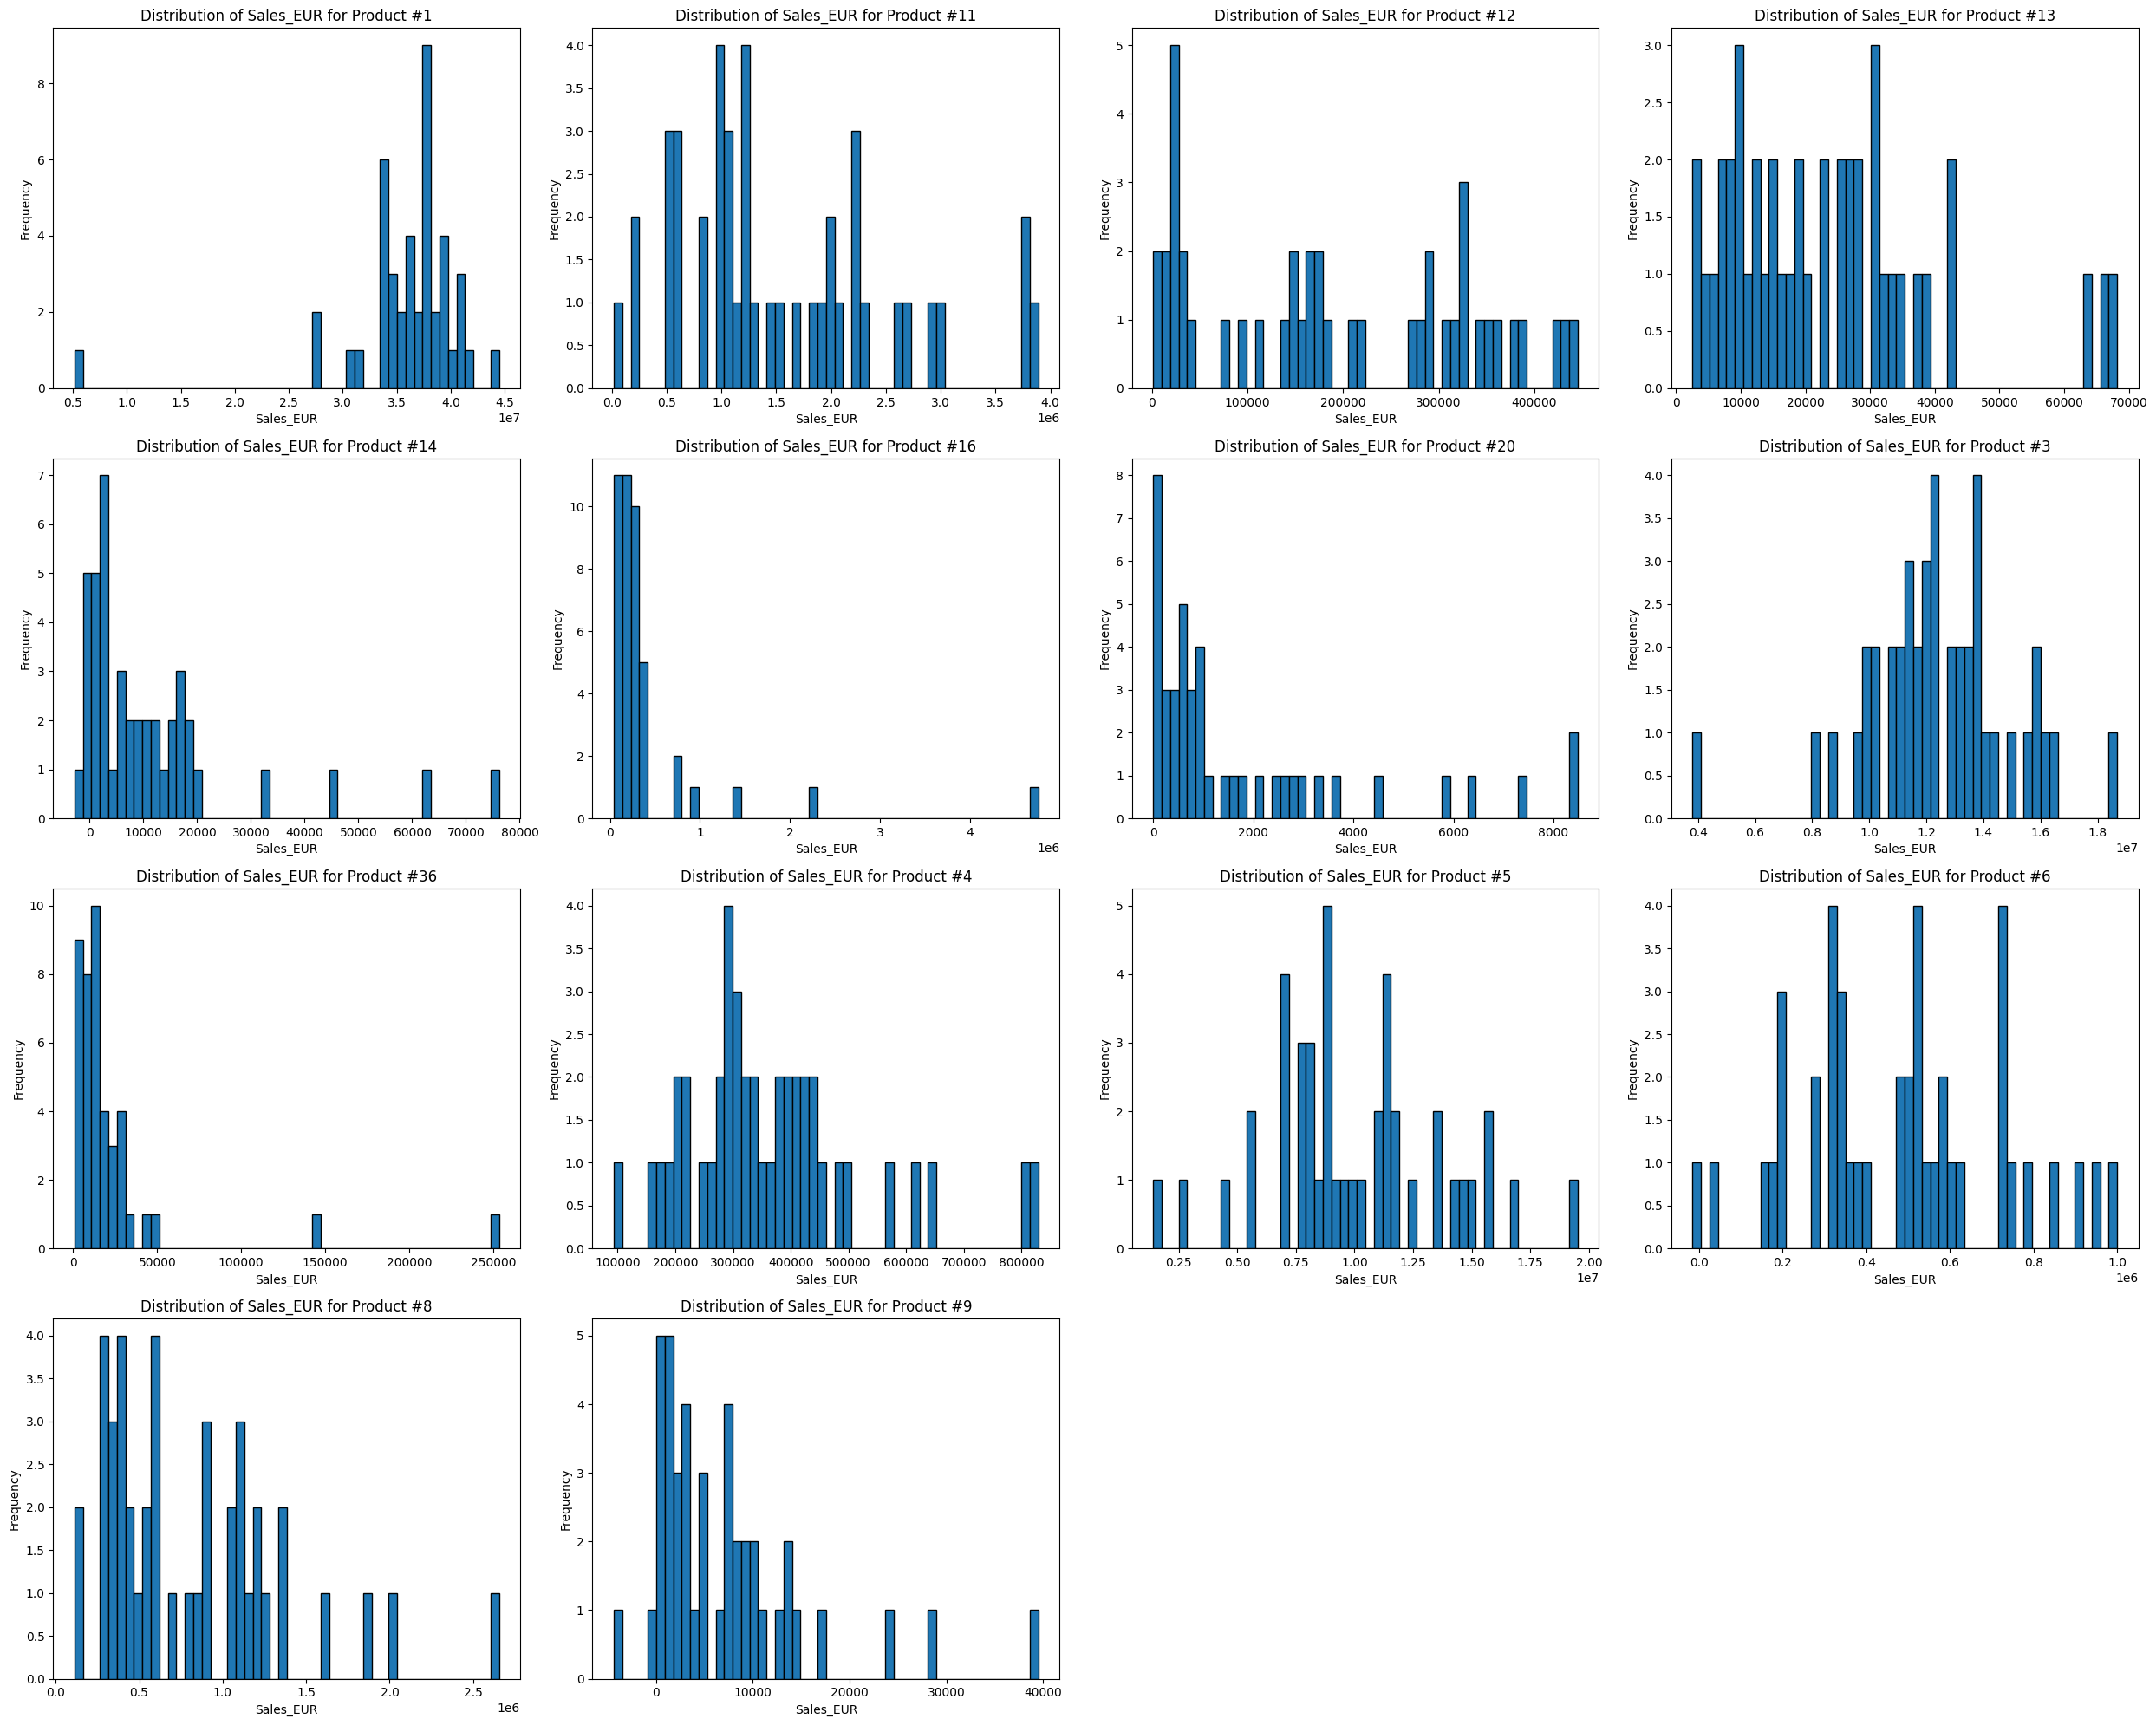

In [25]:
unique_products = monthly_sales_data["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    axes[i].hist(monthly_sales_data[monthly_sales_data["Mapped_GCK"] == product]["Sales_EUR"], bins=50, edgecolor="black")
    axes[i].set_title(f"Distribution of Sales_EUR for Product {product}")
    axes[i].set_xlabel("Sales_EUR")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Check the Negative Values in Sales_EUR

In [26]:
negative_values = monthly_sales_data[monthly_sales_data["Sales_EUR"] < 0]
print(negative_values)

    Mapped_GCK  Year  Month  Sales_EUR
190        #14  2020      4      -2851
207        #14  2021      9       -560
488         #6  2020      1     -15204
584         #9  2020     11      -4358


Set Negative Sales Values to 0

In [27]:
monthly_sales_data["Sales_EUR"] = monthly_sales_data["Sales_EUR"].clip(lower=0)

Apply Log Transformation

In [28]:
epsilon = abs(monthly_sales_data["Sales_EUR"].min()) + 1 
monthly_sales_data["Sales_EUR_Log"] = np.log1p(monthly_sales_data["Sales_EUR"] + epsilon)

monthly_sales_data.head()

,Mapped_GCK,Year,Month,Sales_EUR,Sales_EUR_Log
0,#1,2018,10,36098918,17.401774
1,#1,2018,11,5140757,15.452711
2,#1,2018,12,37889610,17.450188
3,#1,2019,1,27728146,17.137959
4,#1,2019,2,34793162,17.364931


Distribution of Sales_EUR after Log Transform

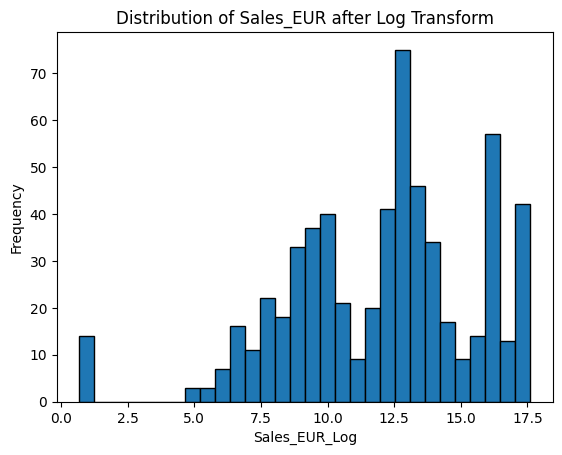

In [29]:
plt.hist(monthly_sales_data["Sales_EUR_Log"], bins=30, edgecolor="black")
plt.title("Distribution of Sales_EUR after Log Transform")
plt.xlabel("Sales_EUR_Log")
plt.ylabel("Frequency")
plt.show()

Describe the Sales_EUR_Log

In [30]:
print(monthly_sales_data["Sales_EUR_Log"].describe())

count    602.000000
mean      11.978277
std        3.559584
min        0.693147
25%        9.529556
50%       12.581674
75%       14.280167
max       17.610618
Name: Sales_EUR_Log, dtype: float64


Box-Cox Transformation

In [31]:
monthly_sales_data["Sales_EUR_Shifted"] = monthly_sales_data["Sales_EUR"] + abs(monthly_sales_data["Sales_EUR"].min()) + 1
monthly_sales_data["Sales_EUR_BoxCox"], lambda_ = boxcox(monthly_sales_data["Sales_EUR_Shifted"])

print(f"Optimal Box-Cox Lambda: {lambda_}")

Optimal Box-Cox Lambda: 0.06616098812963389


To reduce the impact of outliers and stabilize variance in Sales_EUR, we tested a Box-Cox transformation. The resulting lambda was 0.066, which is very close to zero and this confirms that a log transformation is already appropriate for our data, as Box-Cox behaves like log(x) when λ ≈ 0.

We therefore **kept the log transformation** as our chosen method for normalizing sales values.

Monthly Sales Trend for Product

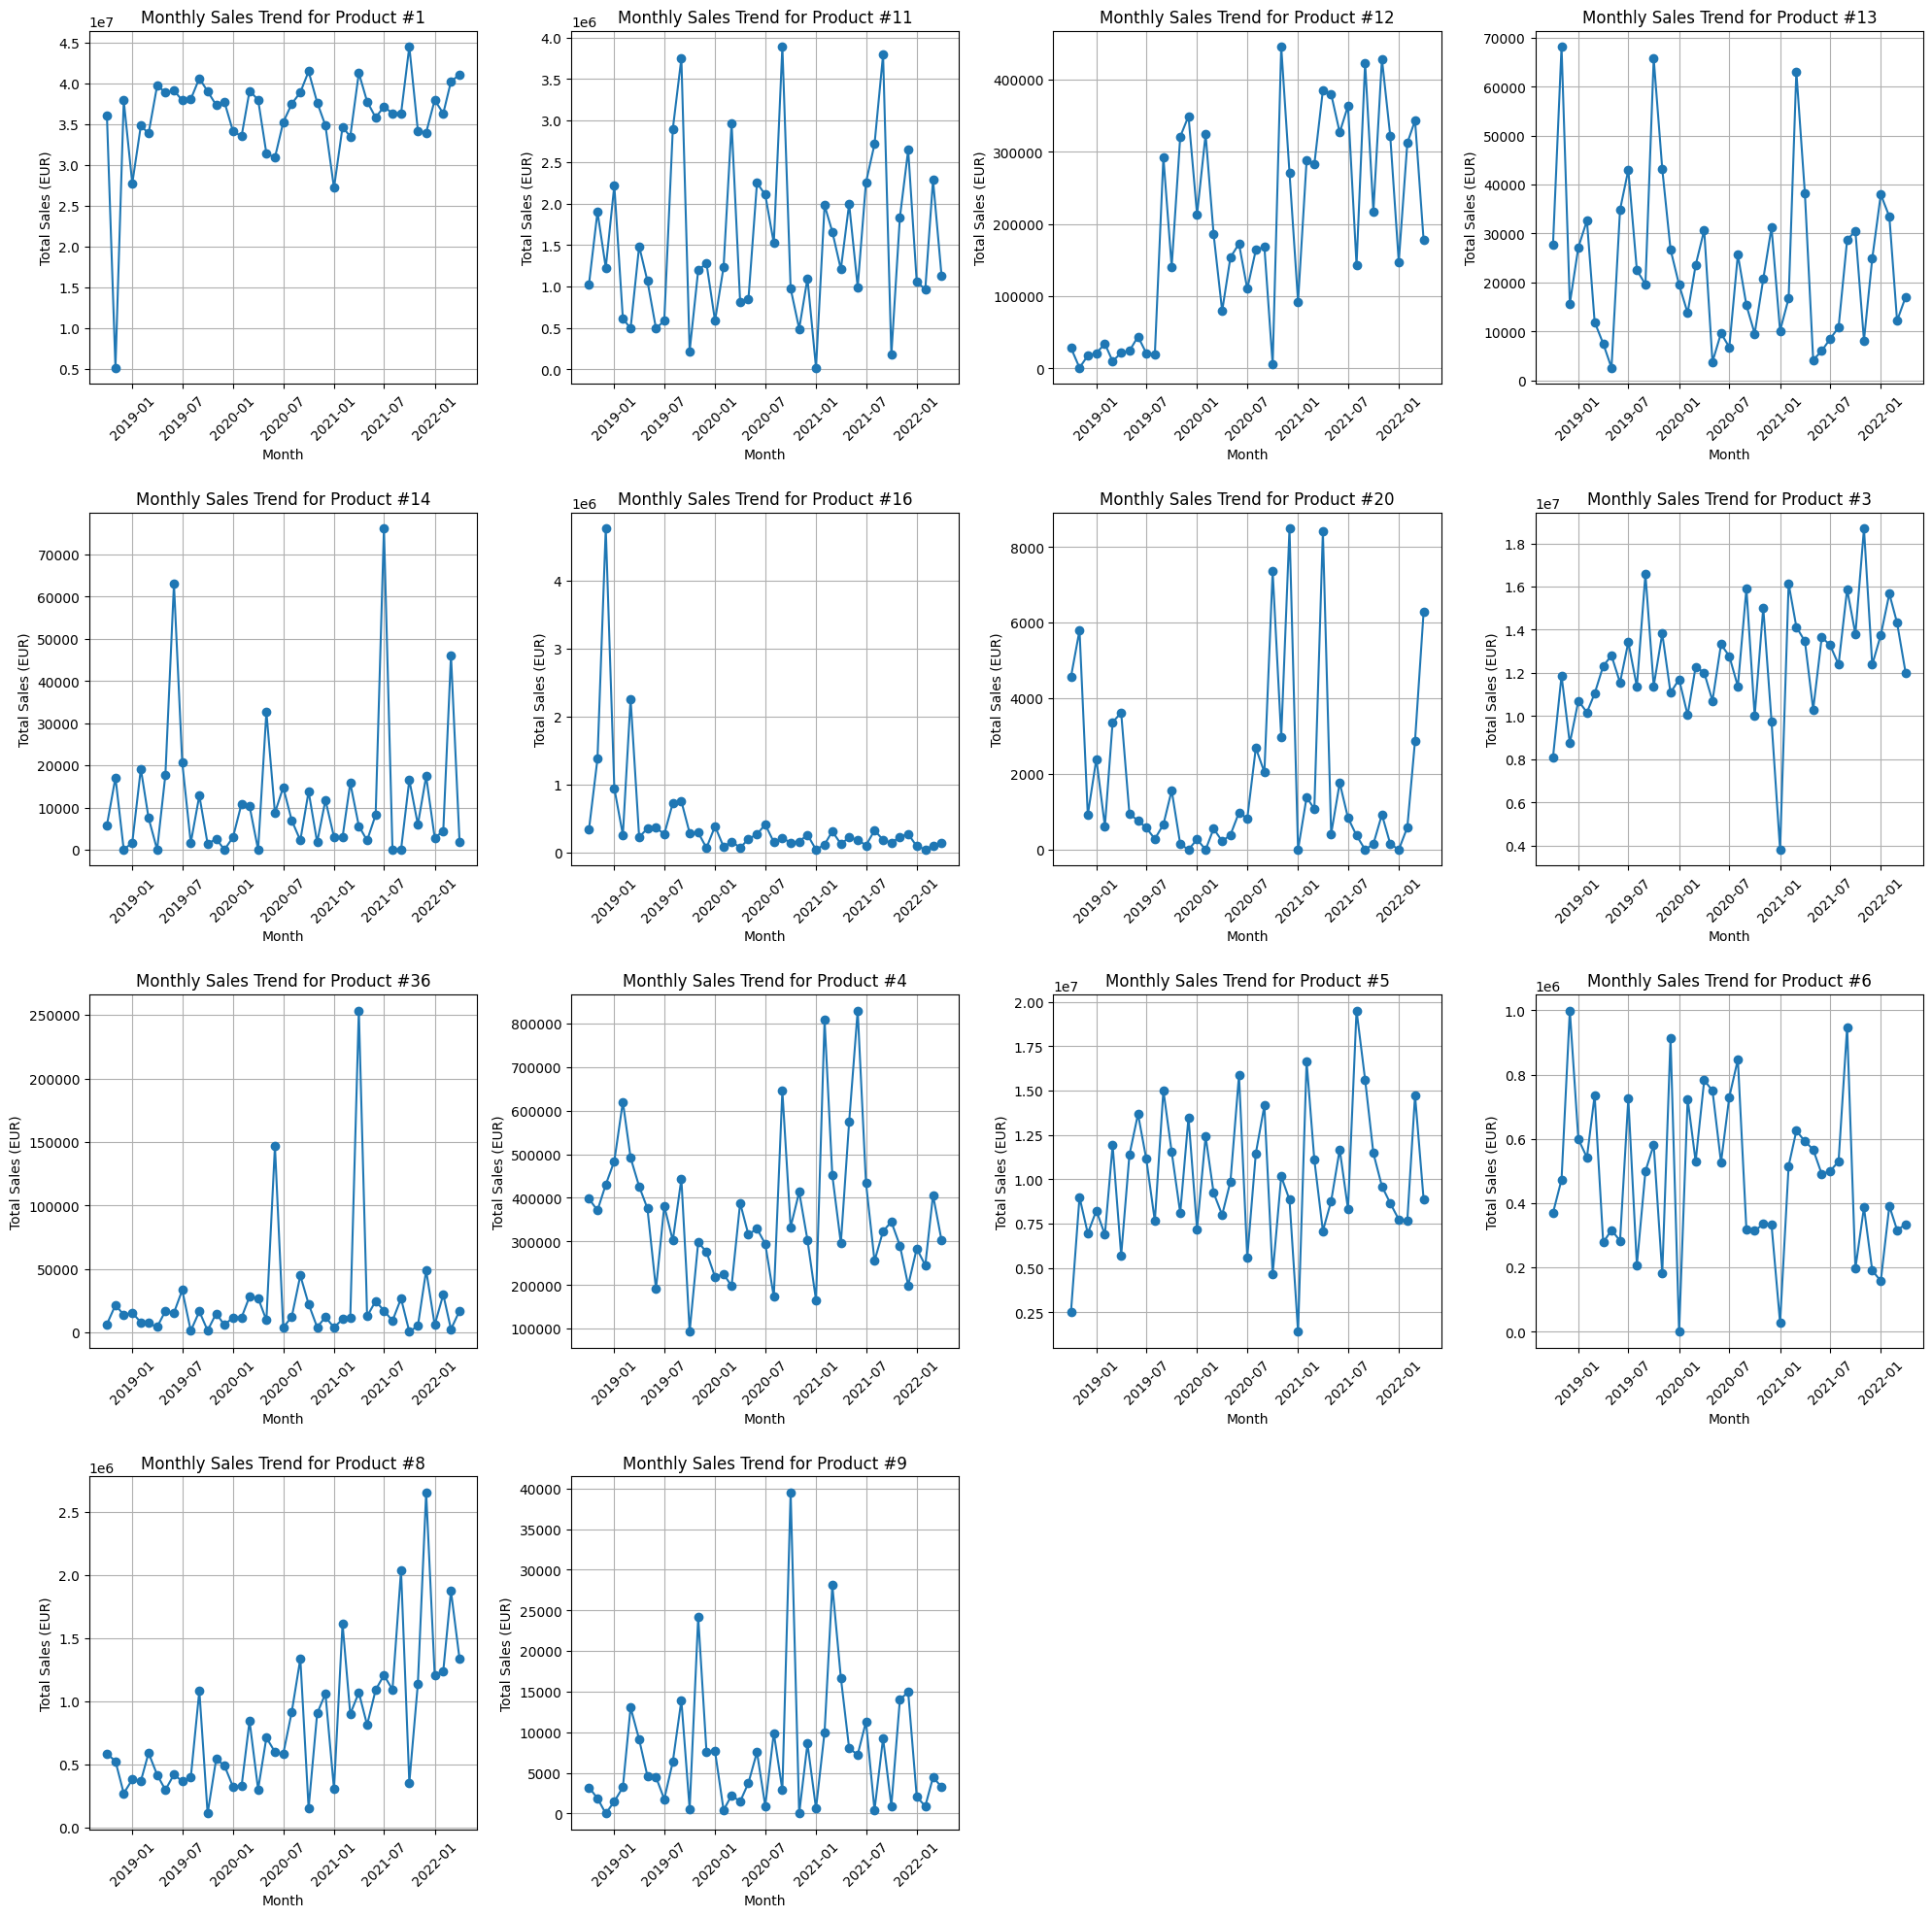

In [32]:
monthly_sales_data["Date"] = pd.to_datetime(monthly_sales_data["Year"].astype(str) + "-" + monthly_sales_data["Month"].astype(str) + "-01")
unique_products = monthly_sales_data["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    product_data = monthly_sales_data[monthly_sales_data["Mapped_GCK"] == product]
    axes[i].plot(product_data["Date"], product_data["Sales_EUR"], marker="o", linestyle="-")
    axes[i].set_title(f"Monthly Sales Trend for Product {product}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Total Sales (EUR)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

monthly_sales_data = monthly_sales_data.drop(columns=["Date"])

### 7. Building the Final Dataset

Merging Data to Create Final Dataset

In [33]:
market_selected = market_data[["Year", "Month", "Key_Materials_Price_Index", "China - Production Index Machinery & Electricals"]]
merged_data = monthly_sales_data.merge(market_selected, on=["Year", "Month"], how="left")

print(merged_data.head()) 

  Mapped_GCK  Year  Month  Sales_EUR  Sales_EUR_Log  Sales_EUR_Shifted  \
0         #1  2018     10   36098918      17.401774           36098919   
1         #1  2018     11    5140757      15.452711            5140758   
2         #1  2018     12   37889610      17.450188           37889611   
3         #1  2019      1   27728146      17.137959           27728147   
4         #1  2019      2   34793162      17.364931           34793163   

   Sales_EUR_BoxCox Key_Materials_Price_Index  \
0         32.683306                 91.485525   
1         26.900530                 82.337572   
2         32.836654                 76.632765   
3         31.856267                 76.966467   
4         32.566940                 81.432649   

  China - Production Index Machinery & Electricals  
0                                       211.955755  
1                                       220.519655  
2                                       241.846854  
3                                       175.6681

Renaming Columns for Clarity

In [34]:
merged_data.rename(columns={
    "China - Production Index Machinery & Electricals": "Global_Industrial_Activity_Index"
}, inplace=True)

Converting Product Variable to Integer Type

In [35]:
merged_data["Mapped_GCK"] = merged_data["Mapped_GCK"].str.replace("#", "").str.strip()

merged_data["Mapped_GCK"] = merged_data["Mapped_GCK"].astype(int)

Removing Unused Transformation Columns

In [36]:
merged_data = merged_data.drop(columns=["Sales_EUR_BoxCox", "Sales_EUR_Shifted"])
merged_data.head(5)

,Mapped_GCK,Year,Month,Sales_EUR,Sales_EUR_Log,Key_Materials_Price_Index,Global_Industrial_Activity_Index
0,1,2018,10,36098918,17.401774,91.485525,211.955755
1,1,2018,11,5140757,15.452711,82.337572,220.519655
2,1,2018,12,37889610,17.450188,76.632765,241.846854
3,1,2019,1,27728146,17.137959,76.966467,175.668147
4,1,2019,2,34793162,17.364931,81.432649,175.668147


### 8. Modelling

Time-Based Train-Test Split

In [37]:
merged_data = merged_data.sort_values(by=["Year", "Month"])
split_point = int(len(merged_data) * 0.8)

train_data = merged_data.iloc[:split_point]
test_data = merged_data.iloc[split_point:]

print(f"Train set size: {len(train_data)} rows")
print(f"Test set size: {len(test_data)} rows")


Train set size: 481 rows
Test set size: 121 rows


Calculating Acceptable RMSE Threshold per Product

In [38]:
ACCEPTABLE_PERCENTAGE = 20  

rmse_thresholds = []

for product_id in train_data["Mapped_GCK"].unique():
    mean_sales = train_data[train_data["Mapped_GCK"] == product_id]["Sales_EUR"].mean()
    threshold = (ACCEPTABLE_PERCENTAGE / 100) * mean_sales 
    rmse_thresholds.append([product_id, int(threshold)])  

rmse_threshold_df = pd.DataFrame(rmse_thresholds, columns=["Mapped_GCK", "RMSE_Threshold"])

rmse_threshold_df


,Mapped_GCK,RMSE_Threshold
0,1,7084553
1,11,297275
2,12,33747
3,13,4664
4,14,2297
5,16,99230
6,20,393
7,3,2379902
8,36,5014
9,4,76331


# ACF & PCF

<Figure size 1000x600 with 0 Axes>

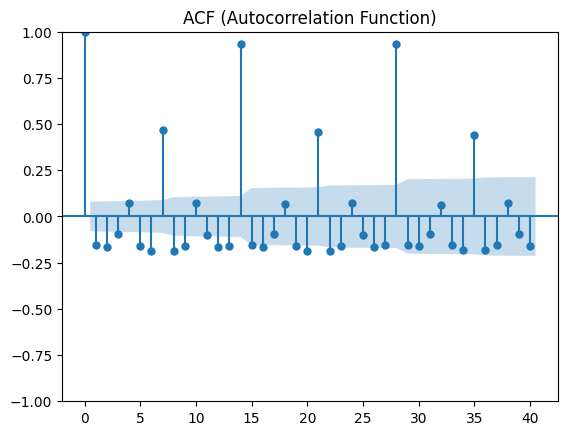

<Figure size 1000x600 with 0 Axes>

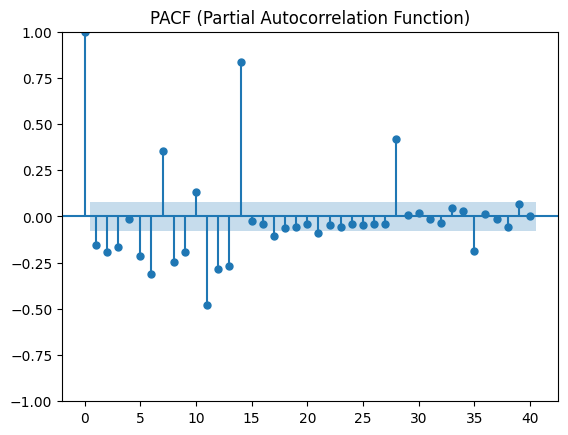

In [39]:
plt.figure(figsize=(10, 6))
plot_acf(merged_data['Sales_EUR'], lags=40)
plt.title('ACF (Autocorrelation Function)')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(merged_data['Sales_EUR'], lags=40)
plt.title('PACF (Partial Autocorrelation Function)')
plt.show()

# Prophet

In [40]:
def train_prophet_with_log_and_regressors(product_id):
    print(f"Training Prophet with regressors for Product {product_id}...")

    product_train = train_data[train_data["Mapped_GCK"] == product_id].copy()
    if product_train.empty:
        print(f"No training data for Product {product_id}")
        return None

    # Prepare training data
    prophet_df = product_train.rename(columns={"Sales_EUR_Log": "y"})
    prophet_df["ds"] = pd.to_datetime(prophet_df["Year"].astype(str) + "-" + prophet_df["Month"].astype(str) + "-01")

    prophet_df["Key_Materials_Price_Index"] = prophet_df["Key_Materials_Price_Index"].astype(float)
    prophet_df["Global_Industrial_Activity_Index"] = prophet_df["Global_Industrial_Activity_Index"].astype(float)
    prophet_df["Month"] = prophet_df["Month"].astype(int)
    prophet_df["Year"] = prophet_df["Year"].astype(int)

    prophet_df = prophet_df[["ds", "y", "Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]]

    # Build model with all regressors
    model = Prophet()
    model.add_regressor("Key_Materials_Price_Index")
    model.add_regressor("Global_Industrial_Activity_Index")
    model.add_regressor("Month")
    model.add_regressor("Year")

    model.fit(prophet_df)

    # Prepare test data
    product_test = test_data[test_data["Mapped_GCK"] == product_id].copy()
    if product_test.empty:
        print(f"No test data for Product {product_id}")
        return None

    product_test["ds"] = pd.to_datetime(product_test["Year"].astype(str) + "-" + product_test["Month"].astype(str) + "-01")

    future = product_test[["ds", "Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].drop_duplicates()
    future["Key_Materials_Price_Index"] = future["Key_Materials_Price_Index"].astype(float)
    future["Global_Industrial_Activity_Index"] = future["Global_Industrial_Activity_Index"].astype(float)
    future["Month"] = future["Month"].astype(int)
    future["Year"] = future["Year"].astype(int)

    # Forecast
    forecast = model.predict(future)

    # Join predictions with actuals for evaluation
    merged = product_test.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    merged = merged.dropna(subset=["Sales_EUR_Log", "yhat"])

    if merged.empty:
        print(f"No valid forecasted data for RMSE calculation for Product {product_id}")
        return None

    # Evaluate
    rmse_log = np.sqrt(mean_squared_error(merged["Sales_EUR_Log"], merged["yhat"]))

    actual_eur = np.expm1(merged["Sales_EUR_Log"])
    predicted_eur = np.expm1(merged["yhat"])
    rmse_eur = np.sqrt(mean_squared_error(actual_eur, predicted_eur))

    mean_actual_eur = actual_eur.mean()
    rmse_percent = (rmse_eur / mean_actual_eur) * 100 if mean_actual_eur != 0 else np.nan

    print(f"Product {product_id} - RMSE (log): {rmse_log:.4f} | RMSE (€): {int(rmse_eur):,} EUR | Percent: {rmse_percent:.2f}%")

    return {
        "Mapped_GCK": product_id,
        "RMSE_Log": rmse_log,
        "RMSE_EUR": rmse_eur,
        "RMSE_Percent": rmse_percent
    }


In [41]:
results = []

for pid in test_data['Mapped_GCK'].unique():
    result = train_prophet_with_log_and_regressors(pid)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by="Mapped_GCK", ascending=True)

results_df["RMSE_EUR"] = results_df["RMSE_EUR"].apply(lambda x: f"{int(x):,}".replace(",", "."))
results_df["RMSE_Percent"] = results_df["RMSE_Percent"].apply(lambda x: f"{x:.2f}%")
results_df["RMSE_Log"] = results_df["RMSE_Log"].apply(lambda x: f"{x:.4f}")

print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))


02:10:39 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet with regressors for Product 16...


02:10:39 - cmdstanpy - INFO - Chain [1] done processing
02:10:39 - cmdstanpy - INFO - Chain [1] start processing


Product 16 - RMSE (log): 0.7175 | RMSE (€): 109,536 EUR | Percent: 64.78%
Training Prophet with regressors for Product 20...


02:10:40 - cmdstanpy - INFO - Chain [1] done processing
02:10:40 - cmdstanpy - INFO - Chain [1] start processing


Product 20 - RMSE (log): 2.4515 | RMSE (€): 2,154 EUR | Percent: 170.50%
Training Prophet with regressors for Product 3...


02:10:40 - cmdstanpy - INFO - Chain [1] done processing
02:10:40 - cmdstanpy - INFO - Chain [1] start processing


Product 3 - RMSE (log): 0.3118 | RMSE (€): 3,367,217 EUR | Percent: 23.52%
Training Prophet with regressors for Product 36...


02:10:41 - cmdstanpy - INFO - Chain [1] done processing
02:10:41 - cmdstanpy - INFO - Chain [1] start processing


Product 36 - RMSE (log): 1.3083 | RMSE (€): 14,918 EUR | Percent: 91.84%
Training Prophet with regressors for Product 4...


02:10:41 - cmdstanpy - INFO - Chain [1] done processing
02:10:41 - cmdstanpy - INFO - Chain [1] start processing


Product 4 - RMSE (log): 0.6708 | RMSE (€): 324,281 EUR | Percent: 110.10%
Training Prophet with regressors for Product 5...


02:10:42 - cmdstanpy - INFO - Chain [1] done processing
02:10:42 - cmdstanpy - INFO - Chain [1] start processing


Product 5 - RMSE (log): 0.6423 | RMSE (€): 5,542,136 EUR | Percent: 48.00%
Training Prophet with regressors for Product 6...


02:10:42 - cmdstanpy - INFO - Chain [1] done processing
02:10:42 - cmdstanpy - INFO - Chain [1] start processing


Product 6 - RMSE (log): 2.2498 | RMSE (€): 382,464 EUR | Percent: 99.80%
Training Prophet with regressors for Product 8...


02:10:43 - cmdstanpy - INFO - Chain [1] done processing
02:10:43 - cmdstanpy - INFO - Chain [1] start processing


Product 8 - RMSE (log): 0.3752 | RMSE (€): 603,691 EUR | Percent: 41.99%
Training Prophet with regressors for Product 9...


02:10:43 - cmdstanpy - INFO - Chain [1] done processing
02:10:43 - cmdstanpy - INFO - Chain [1] start processing


Product 9 - RMSE (log): 3.3496 | RMSE (€): 85,746 EUR | Percent: 1533.87%
Training Prophet with regressors for Product 1...


02:10:43 - cmdstanpy - INFO - Chain [1] done processing
02:10:44 - cmdstanpy - INFO - Chain [1] start processing


Product 1 - RMSE (log): 0.2119 | RMSE (€): 6,525,184 EUR | Percent: 17.15%
Training Prophet with regressors for Product 11...


02:10:44 - cmdstanpy - INFO - Chain [1] done processing
02:10:44 - cmdstanpy - INFO - Chain [1] start processing


Product 11 - RMSE (log): 1.0429 | RMSE (€): 870,818 EUR | Percent: 50.20%
Training Prophet with regressors for Product 12...


02:10:44 - cmdstanpy - INFO - Chain [1] done processing
02:10:45 - cmdstanpy - INFO - Chain [1] start processing


Product 12 - RMSE (log): 1.1827 | RMSE (€): 719,735 EUR | Percent: 242.57%
Training Prophet with regressors for Product 13...


02:10:45 - cmdstanpy - INFO - Chain [1] done processing
02:10:45 - cmdstanpy - INFO - Chain [1] start processing


Product 13 - RMSE (log): 0.8138 | RMSE (€): 16,039 EUR | Percent: 66.56%
Training Prophet with regressors for Product 14...


02:10:45 - cmdstanpy - INFO - Chain [1] done processing


Product 14 - RMSE (log): 3.7534 | RMSE (€): 15,690 EUR | Percent: 132.00%
╒══════════════╤════════════╤════════════╤════════════════╕
│   Mapped_GCK │   RMSE_Log │ RMSE_EUR   │ RMSE_Percent   │
╞══════════════╪════════════╪════════════╪════════════════╡
│            1 │     0.2119 │ 6.525.184  │ 17.15%         │
├──────────────┼────────────┼────────────┼────────────────┤
│            3 │     0.3118 │ 3.367.217  │ 23.52%         │
├──────────────┼────────────┼────────────┼────────────────┤
│            4 │     0.6708 │ 324.281    │ 110.10%        │
├──────────────┼────────────┼────────────┼────────────────┤
│            5 │     0.6423 │ 5.542.136  │ 48.00%         │
├──────────────┼────────────┼────────────┼────────────────┤
│            6 │     2.2498 │ 382.464    │ 99.80%         │
├──────────────┼────────────┼────────────┼────────────────┤
│            8 │     0.3752 │ 603.691    │ 41.99%         │
├──────────────┼────────────┼────────────┼────────────────┤
│            9 │     3.349

# XGBoost

In [42]:
def train_xgboost_with_log_and_regressors(product_id):
    print(f"Training XGBoost with regressors for Product {product_id}...")

    product_train = train_data[train_data["Mapped_GCK"] == product_id].copy()
    if product_train.empty:
        print(f"No training data for Product {product_id}")
        return None

    X_train = product_train[["Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].astype(float)
    y_train = product_train["Sales_EUR_Log"]

    model = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    product_test = test_data[test_data["Mapped_GCK"] == product_id].copy()
    if product_test.empty:
        print(f"No test data for Product {product_id}")
        return None

    X_test = product_test[["Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].astype(float)

    y_pred_log = model.predict(X_test)

    product_test["yhat"] = y_pred_log
    merged = product_test.dropna(subset=["Sales_EUR_Log", "yhat"])

    if merged.empty:
        print(f"No valid forecasted data for RMSE calculation for Product {product_id}")
        return None

    rmse_log = np.sqrt(mean_squared_error(merged["Sales_EUR_Log"], merged["yhat"]))

    actual_eur = np.expm1(merged["Sales_EUR_Log"])
    predicted_eur = np.expm1(merged["yhat"])
    rmse_eur = np.sqrt(mean_squared_error(actual_eur, predicted_eur))

    mean_actual_eur = actual_eur.mean()
    rmse_percent = (rmse_eur / mean_actual_eur) * 100 if mean_actual_eur != 0 else np.nan

    print(f"Product {product_id} - RMSE (log): {rmse_log:.4f} | RMSE (€): {int(rmse_eur):,} EUR | Percent: {rmse_percent:.2f}%")

    return {
        "Mapped_GCK": product_id,
        "RMSE_Log": rmse_log,
        "RMSE_EUR": rmse_eur,
        "RMSE_Percent": rmse_percent
    }


In [43]:
results_xgb = []

for pid in test_data['Mapped_GCK'].unique():
    result = train_xgboost_with_log_and_regressors(pid)
    if result:
        results_xgb.append(result)

results_xgb_df = pd.DataFrame(results_xgb)

results_xgb_df = results_xgb_df.sort_values(by="Mapped_GCK", ascending=True)
results_xgb_df["RMSE_EUR"] = results_xgb_df["RMSE_EUR"].apply(lambda x: f"{int(x):,}".replace(",", "."))
results_xgb_df["RMSE_Percent"] = results_xgb_df["RMSE_Percent"].apply(lambda x: f"{x:.2f}%")
results_xgb_df["RMSE_Log"] = results_xgb_df["RMSE_Log"].apply(lambda x: f"{x:.4f}")

print("\nXGBoost Results")
print(tabulate(results_xgb_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Training XGBoost with regressors for Product 16...
Product 16 - RMSE (log): 0.5265 | RMSE (€): 83,560 EUR | Percent: 49.41%
Training XGBoost with regressors for Product 20...
Product 20 - RMSE (log): 3.3209 | RMSE (€): 2,024 EUR | Percent: 160.23%
Training XGBoost with regressors for Product 3...
Product 3 - RMSE (log): 0.4607 | RMSE (€): 4,197,702 EUR | Percent: 29.32%
Training XGBoost with regressors for Product 36...
Product 36 - RMSE (log): 1.7753 | RMSE (€): 45,467 EUR | Percent: 279.91%
Training XGBoost with regressors for Product 4...
Product 4 - RMSE (log): 0.7121 | RMSE (€): 318,853 EUR | Percent: 108.25%
Training XGBoost with regressors for Product 5...
Product 5 - RMSE (log): 0.7028 | RMSE (€): 5,449,099 EUR | Percent: 47.19%
Training XGBoost with regressors for Product 6...
Product 6 - RMSE (log): 0.7818 | RMSE (€): 251,084 EUR | Percent: 65.52%
Training XGBoost with regressors for Product 8...
Product 8 - RMSE (log): 0.5913 | RMSE (€): 741,725 EUR | Percent: 51.59%
Trainin

# RF

In [44]:
def train_random_forest_with_log_and_regressors(product_id):
    print(f"Training Random Forest with regressors for Product {product_id}...")

    product_train = train_data[train_data["Mapped_GCK"] == product_id].copy()
    if product_train.empty:
        print(f"No training data for Product {product_id}")
        return None

    X_train = product_train[["Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].astype(float)
    y_train = product_train["Sales_EUR_Log"]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    product_test = test_data[test_data["Mapped_GCK"] == product_id].copy()
    if product_test.empty:
        print(f"No test data for Product {product_id}")
        return None

    X_test = product_test[["Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].astype(float)

    y_pred_log = model.predict(X_test)

    product_test["yhat"] = y_pred_log
    merged = product_test.dropna(subset=["Sales_EUR_Log", "yhat"])

    if merged.empty:
        print(f"No valid forecasted data for RMSE calculation for Product {product_id}")
        return None

    rmse_log = np.sqrt(mean_squared_error(merged["Sales_EUR_Log"], merged["yhat"]))

    actual_eur = np.expm1(merged["Sales_EUR_Log"])
    predicted_eur = np.expm1(merged["yhat"])
    rmse_eur = np.sqrt(mean_squared_error(actual_eur, predicted_eur))

    mean_actual_eur = actual_eur.mean()
    rmse_percent = (rmse_eur / mean_actual_eur) * 100 if mean_actual_eur != 0 else np.nan

    print(f"Product {product_id} - RMSE (log): {rmse_log:.4f} | RMSE (€): {int(rmse_eur):,} EUR | Percent: {rmse_percent:.2f}%")

    return {
        "Mapped_GCK": product_id,
        "RMSE_Log": rmse_log,
        "RMSE_EUR": rmse_eur,
        "RMSE_Percent": rmse_percent
    }


In [45]:
results_rf = []

for pid in test_data['Mapped_GCK'].unique():
    result = train_random_forest_with_log_and_regressors(pid)
    if result:
        results_rf.append(result)

results_rf_df = pd.DataFrame(results_rf)

results_rf_df = results_rf_df.sort_values(by="Mapped_GCK", ascending=True)
results_rf_df["RMSE_EUR"] = results_rf_df["RMSE_EUR"].apply(lambda x: f"{int(x):,}".replace(",", "."))
results_rf_df["RMSE_Percent"] = results_rf_df["RMSE_Percent"].apply(lambda x: f"{x:.2f}%")
results_rf_df["RMSE_Log"] = results_rf_df["RMSE_Log"].apply(lambda x: f"{x:.4f}")

print("\nRandom Forest Results")
print(tabulate(results_rf_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Training Random Forest with regressors for Product 16...
Product 16 - RMSE (log): 0.4764 | RMSE (€): 76,459 EUR | Percent: 45.21%
Training Random Forest with regressors for Product 20...
Product 20 - RMSE (log): 2.7570 | RMSE (€): 1,955 EUR | Percent: 154.78%
Training Random Forest with regressors for Product 3...
Product 3 - RMSE (log): 0.3283 | RMSE (€): 3,681,131 EUR | Percent: 25.71%
Training Random Forest with regressors for Product 36...
Product 36 - RMSE (log): 1.5003 | RMSE (€): 16,467 EUR | Percent: 101.38%
Training Random Forest with regressors for Product 4...
Product 4 - RMSE (log): 0.6094 | RMSE (€): 234,129 EUR | Percent: 79.49%
Training Random Forest with regressors for Product 5...
Product 5 - RMSE (log): 0.4387 | RMSE (€): 4,631,358 EUR | Percent: 40.11%
Training Random Forest with regressors for Product 6...
Product 6 - RMSE (log): 0.8117 | RMSE (€): 242,652 EUR | Percent: 63.31%
Training Random Forest with regressors for Product 8...
Product 8 - RMSE (log): 0.5968 | 

# SARIMAX

In [46]:
warnings.filterwarnings("ignore") 

def train_sarima_with_log_and_regressors(product_id):
    print(f"Training SARIMA with regressors for Product {product_id}...")

    product_train = train_data[train_data["Mapped_GCK"] == product_id].copy()
    if product_train.empty:
        print(f"No training data for Product {product_id}")
        return None

    product_train["ds"] = pd.to_datetime(product_train["Year"].astype(str) + "-" + product_train["Month"].astype(str) + "-01")
    product_train.set_index("ds", inplace=True)

    y_train = product_train["Sales_EUR_Log"]
    X_train = product_train[["Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].astype(float)

    try:
        model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
    except:
        print(f"Model fitting failed for Product {product_id}")
        return None

    product_test = test_data[test_data["Mapped_GCK"] == product_id].copy()
    if product_test.empty:
        print(f"No test data for Product {product_id}")
        return None

    product_test["ds"] = pd.to_datetime(product_test["Year"].astype(str) + "-" + product_test["Month"].astype(str) + "-01")
    product_test.set_index("ds", inplace=True)

    X_test = product_test[["Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].astype(float)

    try:
        y_pred_log = results.predict(start=product_test.index.min(), end=product_test.index.max(), exog=X_test)
    except:
        print(f"Prediction failed for Product {product_id}")
        return None

    product_test["yhat"] = y_pred_log
    merged = product_test.dropna(subset=["Sales_EUR_Log", "yhat"])

    if merged.empty:
        print(f"No valid forecasted data for RMSE calculation for Product {product_id}")
        return None

    rmse_log = np.sqrt(mean_squared_error(merged["Sales_EUR_Log"], merged["yhat"]))

    actual_eur = np.expm1(merged["Sales_EUR_Log"])
    predicted_eur = np.expm1(merged["yhat"])
    rmse_eur = np.sqrt(mean_squared_error(actual_eur, predicted_eur))

    mean_actual_eur = actual_eur.mean()
    rmse_percent = (rmse_eur / mean_actual_eur) * 100 if mean_actual_eur != 0 else np.nan

    print(f"Product {product_id} - RMSE (log): {rmse_log:.4f} | RMSE (€): {int(rmse_eur):,} EUR | Percent: {rmse_percent:.2f}%")

    return {
        "Mapped_GCK": product_id,
        "RMSE_Log": rmse_log,
        "RMSE_EUR": rmse_eur,
        "RMSE_Percent": rmse_percent
    }


In [47]:
results_sarima = []

for pid in test_data['Mapped_GCK'].unique():
    result = train_sarima_with_log_and_regressors(pid)
    if result:
        results_sarima.append(result)

results_sarima_df = pd.DataFrame(results_sarima)

results_sarima_df = results_sarima_df.sort_values(by="Mapped_GCK", ascending=True)
results_sarima_df["RMSE_EUR"] = results_sarima_df["RMSE_EUR"].apply(lambda x: f"{int(x):,}".replace(",", "."))
results_sarima_df["RMSE_Percent"] = results_sarima_df["RMSE_Percent"].apply(lambda x: f"{x:.2f}%")
results_sarima_df["RMSE_Log"] = results_sarima_df["RMSE_Log"].apply(lambda x: f"{x:.4f}")

print("\nSARIMA Results")
print(tabulate(results_sarima_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Training SARIMA with regressors for Product 16...
Product 16 - RMSE (log): 1.1723 | RMSE (€): 364,636 EUR | Percent: 215.63%
Training SARIMA with regressors for Product 20...
Product 20 - RMSE (log): 4.4961 | RMSE (€): 34,180 EUR | Percent: 2705.12%
Training SARIMA with regressors for Product 3...
Product 3 - RMSE (log): 0.4305 | RMSE (€): 4,513,775 EUR | Percent: 31.53%
Training SARIMA with regressors for Product 36...
Product 36 - RMSE (log): 1.9075 | RMSE (€): 131,072 EUR | Percent: 806.92%
Training SARIMA with regressors for Product 4...
Product 4 - RMSE (log): 0.7337 | RMSE (€): 377,367 EUR | Percent: 128.12%
Training SARIMA with regressors for Product 5...
Product 5 - RMSE (log): 0.6775 | RMSE (€): 5,683,531 EUR | Percent: 49.22%
Training SARIMA with regressors for Product 6...
Product 6 - RMSE (log): 2.6038 | RMSE (€): 2,616,265 EUR | Percent: 682.66%
Training SARIMA with regressors for Product 8...
Product 8 - RMSE (log): 0.6148 | RMSE (€): 1,030,112 EUR | Percent: 71.65%
Train

**Random Forest** chosen for our final model:
 - Lowest average RMSE_Percent across high-impact GCKs (1, 3, 5)
 - More stable than XGBoost and Prophet (fewer extreme errors)
 - No GCKs with catastrophic % errors (>100%), unlike other models
 - Safe and consistent performance for low-data monthly forecasting

# Forecast on Test Data

Import Test Data

In [48]:
test_set = pd.read_csv("Case2_Test Set Template.csv")
test_set.head(5)

,Month Year,Mapped_GCK,Sales_EUR
0,Mai 22,#3,NaN
1,22-Jun,#3,NaN
2,22-Jul,#3,NaN
3,22-Aug,#3,NaN
4,22-Sep,#3,NaN


Converting 'Month Year' Strings to Numeric Month and Year

In [49]:
month_map = {
    'Jan': 1, 'Fev': 2, 'Feb': 2, 'Mar': 3, 'Abr': 4, 'Apr': 4, 'Mai': 5, 'May': 5,
    'Jun': 6, 'Jul': 7, 'Ago': 8, 'Aug': 8, 'Set': 9, 'Sep': 9, 'Out': 10, 'Okt': 10,
    'Nov': 11, 'Dez': 12, 'Dec': 12
}

def parse_month_year(s):
    parts = s.replace('-', ' ').split()
    month = year = None
    for part in parts:
        if part.isdigit():
            year = int(part)
            if year < 100:
                year += 2000
        else:
            month = month_map.get(part.capitalize())
    return pd.Series([month, year])

test_set[['Month', 'Year']] = test_set['Month Year'].apply(parse_month_year)
test_set['Month'] = test_set['Month'].astype(int)
test_set['Year'] = test_set['Year'].astype(int)

print(test_set.head())

  Month Year Mapped_GCK  Sales_EUR  Month  Year
0     Mai 22         #3        NaN      5  2022
1     22-Jun         #3        NaN      6  2022
2     22-Jul         #3        NaN      7  2022
3     22-Aug         #3        NaN      8  2022
4     22-Sep         #3        NaN      9  2022


Extracting Date Range from Test Set

In [50]:
test_set['YearMonth'] = pd.to_datetime(test_set['Year'].astype(str) + '-' + test_set['Month'].astype(str).str.zfill(2))

first_ym = test_set['YearMonth'].min()
last_ym = test_set['YearMonth'].max()

print("First Year-Month:", first_ym.strftime('%Y-%m'))
print("Last Year-Month:", last_ym.strftime('%Y-%m'))

test_set.drop(columns=['Month Year', "YearMonth"], inplace=True)

First Year-Month: 2022-05
Last Year-Month: 2023-02


Visualizing Historical Trends of Exogenous Variables

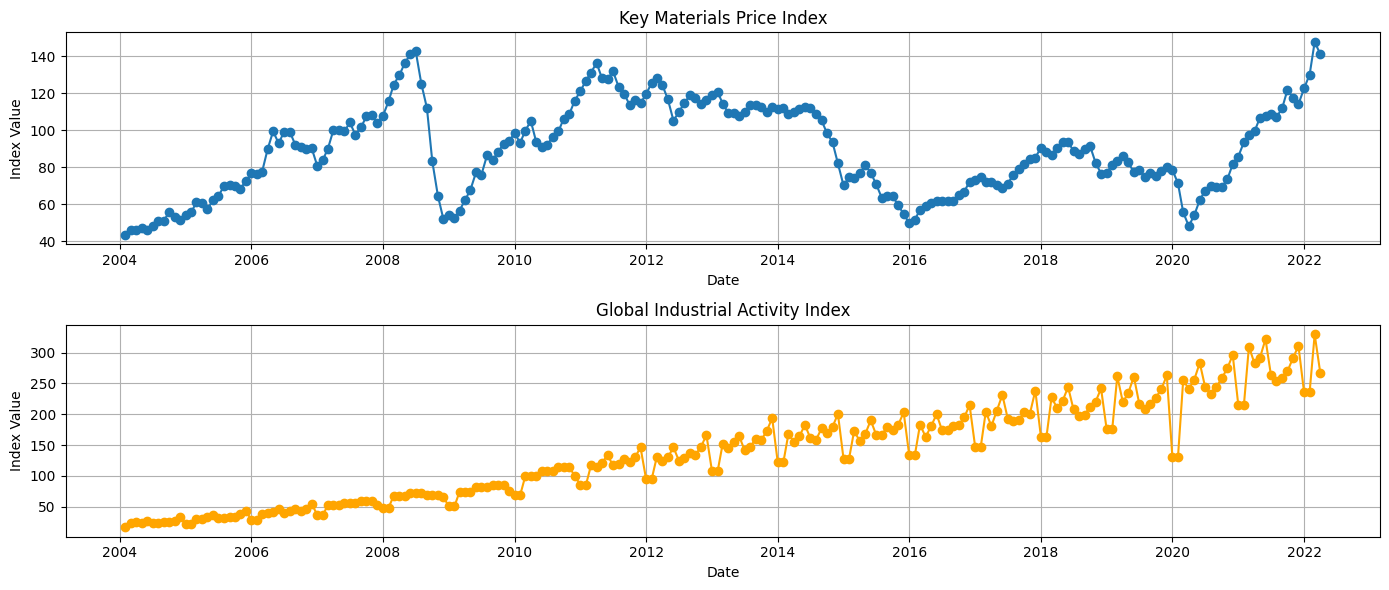

In [51]:
market_data.rename(columns={
    "China - Production Index Machinery & Electricals": "Global_Industrial_Activity_Index"
}, inplace=True)

market_data["Date"] = pd.to_datetime(market_data[["Year", "Month"]].assign(DAY=1))

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(market_data["Date"], market_data["Key_Materials_Price_Index"], marker='o')
plt.title("Key Materials Price Index")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(market_data["Date"], market_data["Global_Industrial_Activity_Index"], marker='o', color='orange')
plt.title("Global Industrial Activity Index")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)

plt.tight_layout()
plt.show()

Forecasting Key_Materials_Price_Index 

In [52]:
kpi_last3_avg = market_data["Key_Materials_Price_Index"].dropna().tail(3).mean()

forecast_mask = (test_set["Year"] == 2022) & (test_set["Month"].between(5, 12)) | \
                (test_set["Year"] == 2023) & (test_set["Month"].between(1, 2))

test_set.loc[forecast_mask, "Key_Materials_Price_Index"] = kpi_last3_avg


Forecasting Global_Industrial_Activity_Index

In [53]:
recent_data = market_data[market_data["Date"] >= "2020-05-01"].copy()
recent_data["TimeIndex"] = np.arange(len(recent_data))

X_recent = recent_data[["TimeIndex"]]
y_recent = recent_data["Global_Industrial_Activity_Index"]
reg_model_recent = LinearRegression().fit(X_recent, y_recent)

forecast_months = test_set[["Year", "Month"]].drop_duplicates().sort_values(["Year", "Month"])
forecast_months["Date"] = pd.to_datetime(forecast_months[["Year", "Month"]].assign(DAY=1))

last_index = recent_data["TimeIndex"].iloc[-1]
forecast_months["TimeIndex"] = np.arange(last_index + 1, last_index + 1 + len(forecast_months))

forecast_months["Global_Industrial_Activity_Index"] = reg_model_recent.predict(forecast_months[["TimeIndex"]])

test_set = test_set.merge(
    forecast_months[["Year", "Month", "Global_Industrial_Activity_Index"]],
    on=["Year", "Month"],
    how="left"
)


Visualizing Historical Data and Forecasts for Exogenous Variables

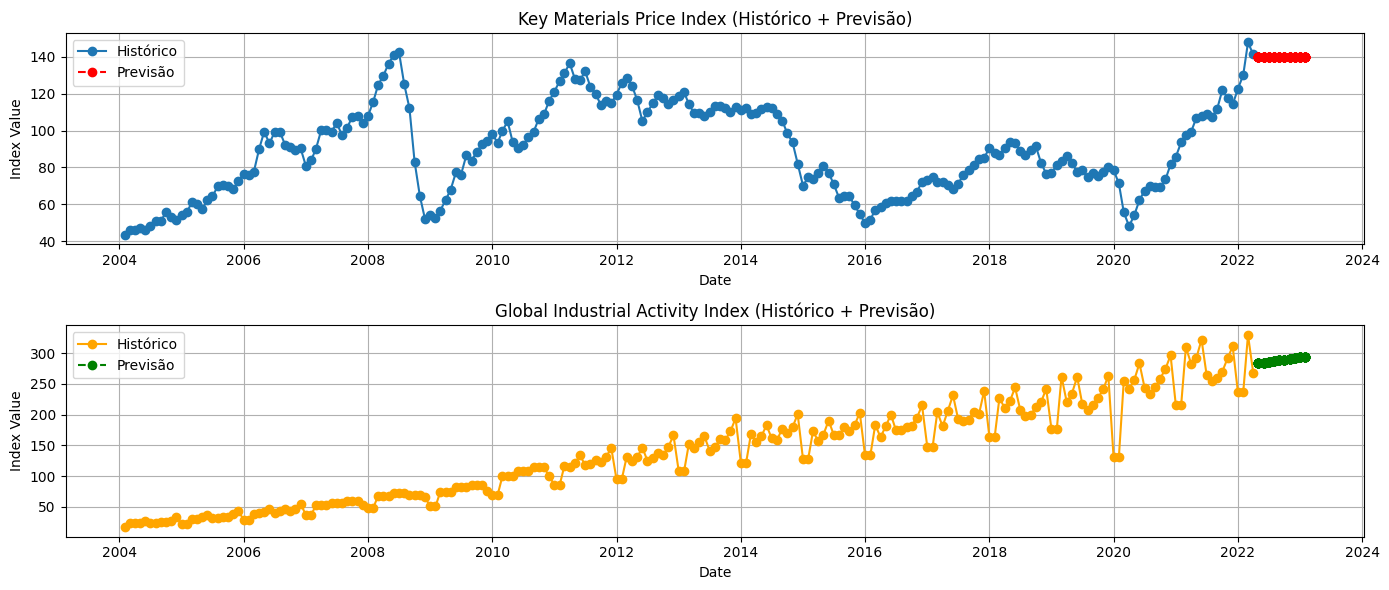

In [54]:
test_set["Date"] = pd.to_datetime(test_set[["Year", "Month"]].assign(DAY=1))

market_data = market_data.sort_values("Date")
test_set = test_set.sort_values("Date")

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(market_data["Date"], market_data["Key_Materials_Price_Index"], marker='o', label="Histórico")
plt.plot(test_set["Date"], test_set["Key_Materials_Price_Index"], marker='o', linestyle='--', color='red', label="Previsão")
plt.title("Key Materials Price Index (Histórico + Previsão)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(market_data["Date"], market_data["Global_Industrial_Activity_Index"], marker='o', color='orange', label="Histórico")
plt.plot(test_set["Date"], test_set["Global_Industrial_Activity_Index"], marker='o', linestyle='--', color='green', label="Previsão")
plt.title("Global Industrial Activity Index (Histórico + Previsão)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**Key_Materials_Price_Index**

We used the average of the last 3 available months as the forecast for the next 10 months.
This approach assumes short-term stabilization after recent growth and avoids introducing volatility or trend assumptions beyond the training period.

**Global_Industrial_Activity_Index**

We applied linear regression using the last 24 months of data to capture the most recent trend dynamics.
This method provides a smooth and consistent continuation aligned with the behavior observed in the latest data window.

---


Cleaning and Converting 'Mapped_GCK' to Integer Format

In [55]:
test_set["Mapped_GCK"] = (
    test_set["Mapped_GCK"]
    .astype(str)
    .str.replace("#", "", regex=False)
    .str.strip()
    .astype(int)
)

#### Predicting Sales_EUR on Test Set

In [56]:
rf_models = {}

for pid in train_data["Mapped_GCK"].unique():
    product_train = train_data[train_data["Mapped_GCK"] == pid].copy()
    if product_train.empty:
        continue

    X_train = product_train[["Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].astype(float)
    y_train = product_train["Sales_EUR_Log"]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    rf_models[pid] = model

print("Models trained for all available GCKs.\n")

predictions = []

for pid in test_set["Mapped_GCK"].unique():
    if pid not in rf_models:
        print(f"No model found for GCK {pid}")
        continue

    model = rf_models[pid]
    subset = test_set[test_set["Mapped_GCK"] == pid].copy()

    X_test = subset[["Key_Materials_Price_Index", "Global_Industrial_Activity_Index", "Month", "Year"]].astype(float)

    yhat_log = model.predict(X_test)

    subset["Sales_EUR"] = np.expm1(yhat_log)

    predictions.append(subset)

final_rf_predictions = pd.concat(predictions, ignore_index=True)


Models trained for all available GCKs.



In [57]:
final_rf_predictions.head(10)

,Mapped_GCK,Sales_EUR,Month,Year,Key_Materials_Price_Index,Global_Industrial_Activity_Index,Date
0,3,1.225747e+07,5,2022,139.71054,283.299248,2022-05-01
1,3,1.260856e+07,6,2022,139.71054,284.490879,2022-06-01
2,3,1.263261e+07,7,2022,139.71054,285.682511,2022-07-01
3,3,1.257710e+07,8,2022,139.71054,286.874143,2022-08-01
4,3,1.310770e+07,9,2022,139.71054,288.065774,2022-09-01
5,3,1.216710e+07,10,2022,139.71054,289.257406,2022-10-01
6,3,1.256965e+07,11,2022,139.71054,290.449037,2022-11-01
7,3,1.068789e+07,12,2022,139.71054,291.640669,2022-12-01
8,3,5.903952e+06,1,2023,139.71054,292.832300,2023-01-01
9,3,1.188240e+07,2,2023,139.71054,294.023932,2023-02-01
